## **Skope rules**

Skope-rules is a framework that extracts rules from ensembles. It differs in the way it learns the final rules: 

1. First, skope-rules remove low-performing rules, based on recall and precision thresholds. 
2. Then, duplicate and similar rules are removed by performing a selection based on the diversity of logical terms (variable + larger/smaller operator) and performance (F1-score) of the rules. 

This final step does not rely on using Lasso as Rulefit, but considers only the out-of-bag F1-score and the logical terms which form the rules.

## **APPLICATIONS**

* Classifications problems (binary label and multilabel)
* CLuster describer: to describe the differences between clusters
* Distribution describer: it is also useful to describe as any subsample differs from a population.

## **PARAMETERS**

In [48]:
!head -15 parameters_skope_rules.txt

    feature_names : list of str, optional
        The names of each feature to be used for returning rules in string
        format.

    precision_min : float, optional (default=0.5)
        The minimal precision of a rule to be selected.

    recall_min : float, optional (default=0.01)
        The minimal recall of a rule to be selected.

    n_estimators : int, optional (default=10)
        The number of base estimators (rules) to use for prediction. More are
        built before selection. All are available in the estimators_ attribute.

    max_samples : int or float, optional (default=.8)


## **Installation**

Follow the instructions in https://github.com/scikit-learn-contrib/skope-rules

In [ ]:
#pip install skope-rules

In [2]:
# Import skope-rules
from skrules import SkopeRules

/home/erikapat/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [3]:
# Import librairies
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve
from matplotlib import cm
import numpy as np
from sklearn.metrics import confusion_matrix
from IPython.display import display

In [4]:
#my own functions
%load_ext autoreload
%autoreload 2

from utils.quality_metrics import *

## **LOAD DATA**

Data from: https://www.kaggle.com/c/titanic

In [5]:
# Import Titanic data
data = pd.read_csv('data/titanic.csv')

In [6]:
data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


## **CLASSIFICATION**

## Data preparation

In [7]:
# Remove rows with age missing
data = data.query('Age == Age')
data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.125,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.000,B42,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.000,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.750,NaN,Q


In [8]:
# Create dummy for variable Sex
data['isFemale'] = (data['Sex'] == 'female') * 1

# Create dummies for variable Embarked
data = pd.concat(
    [data,
    pd.get_dummies(data.loc[:,'Embarked'], dummy_na=False, prefix='Embarked', prefix_sep='_')],
    axis=1
)

# Remove unused columns
data = data.drop(['Name', 'Ticket', 'Cabin', 'PassengerId', 'Sex', 'Embarked'], axis = 1)

In [9]:
# Create training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Survived'], axis=1), data['Survived'], test_size=0.25, random_state=42)
feature_names = X_train.columns

print('Column names are: ' + ' '.join(feature_names.tolist())+'.')
print('Shape of training set is: ' + str(X_train.shape) + '.')

Column names are: Pclass Age SibSp Parch Fare isFemale Embarked_C Embarked_Q Embarked_S.
Shape of training set is: (535, 9).


## **TRAIN DIFFERENT MODELS TO COMPARE**

In [10]:
# Train a gradient boosting classifier for benchmark
gradient_boost_clf = GradientBoostingClassifier(random_state=42, n_estimators=30, max_depth = 5)
gradient_boost_clf.fit(X_train, y_train)

# Train a random forest classifier for benchmark
random_forest_clf = RandomForestClassifier(random_state=42, n_estimators=30, max_depth = 5)
random_forest_clf.fit(X_train, y_train)

# Train a decision tree classifier for benchmark
decision_tree_clf = DecisionTreeClassifier(random_state=42, max_depth = 5)
decision_tree_clf.fit(X_train, y_train)

# Compute prediction scores
gradient_boost_scoring = gradient_boost_clf.predict_proba(X_test)[:, 1]
random_forest_scoring = random_forest_clf.predict_proba(X_test)[:, 1]
decision_tree_scoring = decision_tree_clf.predict_proba(X_test)[:, 1]


## **SKOPE RULES**

In [11]:
# Train a skope-rules-boosting classifier
skope_rules_clf = SkopeRules(feature_names=feature_names, random_state=42, n_estimators=30,
                               recall_min=0.05, precision_min=0.9,
                               max_samples=0.7,
                               max_depth_duplication= 4, max_depth = 5)
skope_rules_clf.fit(X_train, y_train)


skope_rules_scoring = skope_rules_clf.score_top_rules(X_test)

In [12]:
skope_rules_clf

SkopeRules(bootstrap=False, bootstrap_features=False,
           feature_names=Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'isFemale', 'Embarked_C',
       'Embarked_Q', 'Embarked_S'],
      dtype='object'),
           max_depth=5, max_depth_duplication=4, max_features=1.0,
           max_samples=0.7, max_samples_features=1.0, min_samples_split=2,
           n_estimators=30, n_jobs=1, precision_min=0.9, random_state=42,
           recall_min=0.05, verbose=0)

In [13]:
# Get number of survival rules created
print(str(len(skope_rules_clf.rules_)) + ' rules have been built with ' +
      'SkopeRules.\n')


11 rules have been built with SkopeRules.



## **RULE EXPLANATIONS**

### **TOP RULES**
    ' (1) Women under 43.5, who were in first or second class.',
    ' (2) Women aged more than 3 in first or second class, who paid more than 26€.',
    ' (3) Women in first or second class, who paid more than 29€.',
    ' (4) Women aged more than 3 which paid less than 28, in first or second class.'
    ' ...'

In [14]:
for i_rule, rule in enumerate(skope_rules_clf.rules_):
    print(rule)

('Age <= 43.5 and Pclass <= 2.5 and isFemale > 0.5', (0.9661016949152542, 0.3825503355704698, 2))
('Age > 2.5 and Fare > 26.125 and Pclass <= 2.5 and isFemale > 0.5', (0.9805409497831279, 0.3399971993073677, 12))
('Fare > 29.356249809265137 and Pclass <= 2.5 and isFemale > 0.5', (0.9796474683708727, 0.3148718588067946, 14))
('Age > 2.5 and Fare <= 28.231249809265137 and Pclass <= 2.5 and isFemale > 0.5', (0.9357606269370976, 0.21161705297519331, 8))
('Age > 38.5 and Pclass <= 2.5 and isFemale > 0.5', (0.9259259259259259, 0.16025641025641027, 2))
('Age <= 37.0 and Age > 2.5 and Fare <= 29.356249809265137 and Pclass <= 2.5 and isFemale > 0.5', (0.96, 0.1518987341772152, 2))
('Fare <= 28.231249809265137 and Pclass <= 2.5 and SibSp <= 0.5 and isFemale > 0.5', (0.9715151515151514, 0.13377596404947473, 6))
('Age <= 16.5 and Fare <= 23.579150199890137 and Pclass > 2.5 and isFemale > 0.5', (0.9285714285714286, 0.08496732026143791, 2))
('Age <= 16.5 and Pclass > 2.5 and SibSp <= 2.5 and isFemal

## **PERFORMANCE OF THE RULES**

In [15]:
print('Precision = 0.96 means that 96% of people identified by the rule are survivors.')
print('Recall = 0.41 means that the survivors identified by the rule are  41% of the total number of survivors.\n')

for i in range(4):
    print('Rule '+str(i+1)+':')
    display(compute_train_test_query_performances(X_train, y_train,
                                                  X_test, y_test,
                                                  skope_rules_clf.rules_[i][0])
           )

Precision = 0.96 means that 96% of people identified by the rule are survivors.
Recall = 0.41 means that the survivors identified by the rule are  41% of the total number of survivors.

Rule 1:


,precision,recall
train_set,0.957447,0.412844
test_set,0.937500,0.416667


Rule 2:


,precision,recall
train_set,0.986667,0.339450
test_set,0.960000,0.333333


Rule 3:


,precision,recall
train_set,0.985507,0.311927
test_set,0.950000,0.263889


Rule 4:


,precision,recall
train_set,0.913043,0.192661
test_set,0.904762,0.263889


## **COMBINATIONS OF RULES**

### **TWO RULES**

In [16]:
n_rule_chosen = 2
y_pred = skope_rules_clf.predict_top_rules(X_test, n_rule_chosen)

print('The performances reached with '+str(n_rule_chosen)+' discovered rules are the following:')
compute_performances_from_y_pred(y_test, y_pred, 'test_set')

The performances reached with 2 discovered rules are the following:


,precision,recall
test_set,0.947368,0.5


### **FIVE RULES**

In [17]:
n_rule_chosen = 5
y_pred = skope_rules_clf.predict_top_rules(X_test, n_rule_chosen)

print('The performances reached with '+str(n_rule_chosen)+' discovered rules are the following:')
compute_performances_from_y_pred(y_test, y_pred, 'test_set')

The performances reached with 5 discovered rules are the following:


,precision,recall
test_set,0.928571,0.541667


### **ALL RULES**

In [18]:
n_rule_chosen = 11
y_pred = skope_rules_clf.predict_top_rules(X_test, n_rule_chosen)

print('The performances reached with '+str(n_rule_chosen)+' discovered rules are the following:')
compute_performances_from_y_pred(y_test, y_pred, 'test_set')

The performances reached with 11 discovered rules are the following:


,precision,recall
test_set,0.849057,0.625


## **ROC VS. PRECISION AND RECALL**

On the ROC curve, each red point corresponds to a fixed number of rules (from skope-rules). 
**For example**, the lowest point is the performance point for the first rule (the best). The second-lowest point is plot for the two best rules, etc.

On the Precision-Recall curve, the same points are plot but with different axes. The first red point on the left (0% recall, 100% precision) corresponds to 0 rules. The second point on the left is the result of use the first rule, later the two first rules, etc.

Some conclusions can be drawn from this example:
- skope-rules performs better than a decision tree.
- skope-rules have similar performances than a random-forest/gradient boosting (in this example)
- Using 4 rules leads to a great performance (61% recall, 94% precision) (in this example).

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


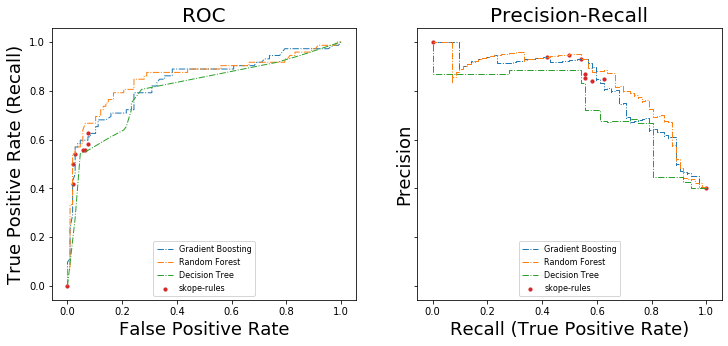

In [19]:
plot_titanic_scores(y_test,
                    scores_with_line=[gradient_boost_scoring, random_forest_scoring, decision_tree_scoring],
                    scores_with_points=[skope_rules_scoring]
                   )

## **CLUSTERING**

### **SPORTS PLAYERS DATA**

The data is extracted for here:  https://www.kaggle.com/thec03u5/fifa-18-demo-player-dataset/data

In [20]:
data = pd.read_csv('data/sports.csv')
data.head()

/home/erikapat/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,2,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,94,Paris Saint-Germain,https://cdn.sofifa.org/24/18/teams/73.png,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,3,L. Suárez,30,https://cdn.sofifa.org/48/18/players/176580.png,Uruguay,https://cdn.sofifa.org/flags/60.png,92,92,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,4,M. Neuer,31,https://cdn.sofifa.org/48/18/players/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,92,92,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###  **PREPARE DATA**

In [21]:
data = data.query("Overall>=85") # Select players with an overall attribute larger than 85/100.

column_to_keep = ['Name', 'Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control',
       'Composure', 'Crossing', 'Curve', 'Dribbling', 'Finishing',
       'Free kick accuracy', 'GK diving', 'GK handling', 'GK kicking',
       'GK positioning', 'GK reflexes', 'Heading accuracy', 'Preferred Positions']
data = data[column_to_keep] # Keep only performance attributes and names.

data.columns = [x.replace(' ', '_') for x in data.columns] # Replace white spaces in the column names

feature_names = data.drop(['Name', 'Preferred_Positions'], axis=1).columns.tolist()

In [22]:
from sklearn.cluster import AgglomerativeClustering
clust = AgglomerativeClustering(n_clusters=4) #with euclidian distance and ward linkage

data['cluster'] = clust.fit_predict(data.drop(['Name', 'Preferred_Positions'], axis=1))

## **Explain each cluster with rules**

In [23]:
i_cluster = 0
for i_cluster in range(4):
    X_train = data.drop(['Name', 'Preferred_Positions', 'cluster'], axis=1)
    y_train = (data['cluster']==i_cluster)*1
    skope_rules_clf = SkopeRules(feature_names=feature_names, random_state=42, n_estimators=5,
                                   recall_min=0.5, precision_min=0.5, max_depth_duplication=0,
                                   max_samples=1., max_depth=3)
    skope_rules_clf.fit(X_train, y_train)
    print('Cluster '+str(i_cluster)+':')
    #print(data.query('cluster=='+str(i_cluster))[['Name', 'Preferred_Positions']])
    print(skope_rules_clf.rules_)

Cluster 0:
[('Agility <= 81.5 and Free_kick_accuracy > 56.0 and Heading_accuracy > 58.5', (0.9354838709677419, 0.8529411764705882, 10))]
Cluster 1:
[('Aggression <= 76.5 and Agility > 81.5 and Balance > 66.5', (1.0, 0.7741935483870968, 8))]
Cluster 2:
[('Curve <= 61.5 and Heading_accuracy > 82.5', (1.0, 0.7857142857142857, 8))]
Cluster 3:
[('Curve <= 28.0', (1.0, 1.0, 4))]


In [24]:
(data['cluster']==1)*1

0     0
1     1
2     1
3     0
4     0
     ..
87    0
88    0
89    0
90    0
91    0
Name: cluster, Length: 92, dtype: int64

In [25]:
for i_cluster in range(4):
    print('5 players from cluster '+str(i_cluster)+':')
    print(data.query("cluster=="+str(i_cluster))['Name'].sample(5, random_state=42).tolist()) # Get 5 random players per cluster
    print()

5 players from cluster 0:
['M. Hamšík', 'Alex Sandro', 'Casemiro', 'K. Benzema', 'Z. Ibrahimović']

5 players from cluster 1:
['H. Mkhitaryan', 'David Silva', 'F. Ribéry', 'J. Rodríguez', 'P. Dybala']

5 players from cluster 2:
['Pepe', 'K. Glik', 'G. Chiellini', 'V. Kompany', 'Piqué']

5 players from cluster 3:
['M. ter Stegen', 'D. Subašić', 'M. Neuer', 'K. Navas', 'H. Lloris']



## **SIMULATED DATA**

In [41]:
rng = np.random.RandomState(42)

n_inliers = 1000
n_outliers = 50

# Generate train data
I = 0.5 * rng.randn(int(n_inliers / 2), 2)
X_inliers = np.r_[I + 2, I - 2]
O = 0.5 * rng.randn(n_outliers, 2)
X_outliers = O  # np.r_[O, O + [2, -2]]
X_train = np.r_[X_inliers, X_outliers]
y_train = [0] * n_inliers + [1] * n_outliers

In [45]:
X_train

array([[ 2.24835708,  1.93086785],
       [ 2.32384427,  2.76151493],
       [ 1.88292331,  1.88293152],
       ...,
       [ 0.36632004, -0.04035829],
       [ 0.0393176 , -0.99910034],
       [ 0.45816384,  0.17324424]])

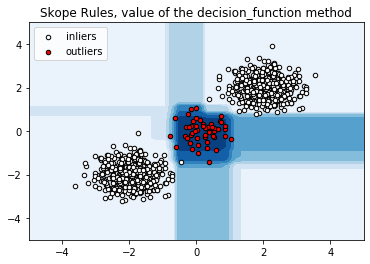

In [42]:
# fit the model
clf = SkopeRules(random_state=rng, n_estimators=10)
clf.fit(X_train, y_train)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Skope Rules, value of the decision_function method")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues)

a = plt.scatter(X_inliers[:, 0], X_inliers[:, 1], c='white',
                s=20, edgecolor='k')
b = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a, b],
           ["inliers", "outliers"],
           loc="upper left")
plt.show()

The 4 most precise rules are the following:
c0 <= 1.0391224026679993 and c0 > -0.6836492121219635 and c1 <= 1.279470682144165
c0 <= 1.0391224026679993 and c0 > -0.6803303956985474 and c1 <= 1.2835460305213928
c0 > -0.8104808330535889 and c1 <= 0.7875268459320068 and c1 > -1.4322419166564941
c0 <= 1.156811773777008 and c0 > -0.6803303956985474 and c1 <= 1.0843470692634583


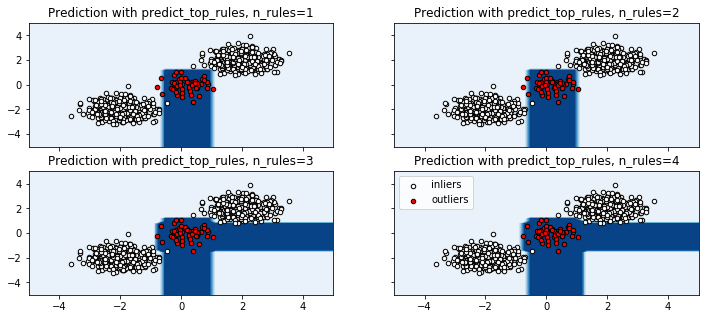

In [43]:
print('The 4 most precise rules are the following:')
for rule in clf.rules_[:4]:
    print(rule[0])

fig, axes = plt.subplots(2, 2, figsize=(12, 5),
                         sharex=True, sharey=True)
for i_ax, ax in enumerate(np.ravel(axes)):
    Z = clf.predict_top_rules(np.c_[xx.ravel(), yy.ravel()], i_ax+1)
    Z = Z.reshape(xx.shape)
    ax.set_title("Prediction with predict_top_rules, n_rules="+str(i_ax+1))
    ax.contourf(xx, yy, Z, cmap=plt.cm.Blues)

    a = ax.scatter(X_inliers[:, 0], X_inliers[:, 1], c='white',
                   s=20, edgecolor='k')
    b = ax.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                   s=20, edgecolor='k')
    ax.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a, b],
           ["inliers", "outliers"],
           loc="upper left")
plt.show()

## **MULTICLASS CLASSIFICATION**